In [9]:
# !pip install -i https://pypi.tuna.tsinghua.edu.cn/simple astunparse

In [1]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import entropy
import gc
import os
from tqdm import tqdm
pd.set_option('display.max_columns', 600)
pd.set_option('display.max_rows', 600)
from IPython.core.interactiveshell import InteractiveShell
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from gensim.models import Word2Vec
from sklearn.model_selection import KFold,StratifiedKFold
import catboost as cat
from scipy import stats
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

# import sklearn.metrics as mtr
# from sklearn.preprocessing import StandardScaler
# from sklearn.model_selection import train_test_split
# from keras.layers import Dense
# from keras.models import Sequential
# from keras.callbacks import Callback, EarlyStopping
# from keras.models import Model
# from keras.layers import Input, Dense, Concatenate, Reshape, Dropout, merge, Add
# from keras.layers.embeddings import Embedding
# from sklearn.model_selection import KFold, GroupKFold, StratifiedKFold
# import warnings
# import random as rn
# import tensorflow as tf
# from keras.models import load_model
# from keras.utils import to_categorical
# import os
# from sklearn.metrics import f1_score
# from collections import Counter
# import keras
# from sklearn.metrics import confusion_matrix
# from tqdm import tqdm


InteractiveShell.ast_node_interactivity = "all"

In [3]:
data_path = 'data/'
data_train = pd.read_csv(data_path+'sensor_train.csv')
data_test = pd.read_csv(data_path+'sensor_test.csv')
data_test['fragment_id'] += 10000
label = 'behavior_id'

In [4]:
data = pd.concat([data_train, data_test], sort=False)
df = data.drop_duplicates(subset=['fragment_id']).reset_index(drop=True)[['fragment_id', 'behavior_id']]

In [5]:
data.head()

,fragment_id,time_point,acc_x,acc_y,acc_z,acc_xg,acc_yg,acc_zg,behavior_id
0,0,27,0.3,-0.3,0.1,0.6,4.5,8.8,0.0
1,0,108,0.1,-0.0,-0.4,0.4,4.7,8.4,0.0
2,0,198,0.1,0.0,0.3,0.9,4.6,9.0,0.0
3,0,297,0.1,-0.1,-0.5,0.8,4.7,7.2,0.0
4,0,388,0.1,0.2,0.6,0.9,4.7,8.9,0.0


In [6]:
df.head()

,fragment_id,behavior_id
0,0,0.0
1,1,0.0
2,2,0.0
3,3,0.0
4,4,0.0


特征工程

In [7]:
accs = ['acc_x', 'acc_y', 'acc_z']
accgs = ['acc_xg', 'acc_yg', 'acc_zg']
two_accs = [['acc_x', 'acc_y'], ['acc_y', 'acc_z'], ['acc_x', 'acc_z']] # ['acc_y', 'acc_x'], ['acc_z', 'acc_y']
two_accgs =  [['acc_xg', 'acc_yg'], ['acc_yg', 'acc_zg'], ['acc_xg', 'acc_zg']] # , ['acc_yg', 'acc_xg'], ['acc_zg', 'acc_yg']
acc_and_accg = accs + accgs

# 坐标特征
data['acc'] = (data['acc_x'] ** 2 + data['acc_y'] ** 2 + data['acc_z'] ** 2) ** 0.5
data['accg'] = (data['acc_xg'] ** 2 + data['acc_yg'] ** 2 + data['acc_zg'] ** 2) ** 0.5

# 展示手机倾斜角度
data['acc_xy_xgyg_gdirect'] = ((data['acc_xg'] - data['acc_x']) ** 2 + (data['acc_yg'] - data['acc_y']) ** 2) ** 0.5
data['acc_yz_ygzy_gdirect'] = ((data['acc_yg'] - data['acc_y']) ** 2 + (data['acc_zg'] - data['acc_z']) ** 2) ** 0.5
data['acc_xz_xgzg_gdirect'] = ((data['acc_zg'] - data['acc_z']) ** 2 + (data['acc_zg'] - data['acc_z']) ** 2) ** 0.5

data['acc_xy_thea1'] = np.arccos(9.8 / (data['acc_xy_xgyg_gdirect'] * ((data['acc_yg'] - data['acc_y']))))
data['acc_yz_thea1'] = np.arccos(9.8 / (data['acc_yz_ygzy_gdirect'] * ((data['acc_zg'] - data['acc_z']))))
data['acc_xz_thea1'] = np.arccos(9.8 / (data['acc_xz_xgzg_gdirect'] * ((data['acc_zg'] - data['acc_z']))))


# diff
for i in range(len(accs)):
    data['{}_diff_{}'.format(accgs[i], accs[i])] = data[accgs[i]] - data[accs[i]]



# div
for i in range(len(accs)):
    data['{}_div_{}'.format(accgs[i], accs[i])] = data[accgs[i]] / (data[accs[i]].apply(lambda x: np.abs(x)) + 0.000000000000000000001)



# two dim
for acc_type in tqdm([['acc_x','acc_y', 'acc_z'], ['acc_xg','acc_yg', 'acc_zg']]):
    for acc in acc_type:
        if acc in ['acc_x', 'acc_xg']:  # ['acc_x', 'acc_xg','acc_xg', 'acc_yg', 'acc_zg']
            data['two_dim_{}_{}'.format(acc, acc_type[1])] = (data[acc] ** 2 + data[acc_type[1]] ** 2) ** 0.5
            data['two_dim_{}_{}'.format(acc, acc_type[2])] = (data[acc] ** 2 + data[acc_type[2]] ** 2) ** 0.5
        elif acc in ['acc_y', 'acc_yg']:
            data['two_dim_{}_{}'.format(acc, acc_type[2])] = (data[acc] ** 2 + data[acc_type[2]] ** 2) ** 0.5


data['phi_acc_y_yz'] = np.arcsin(data['acc_y'] / data['two_dim_acc_y_acc_z'])
data['phi_acc_x_xz'] = np.arcsin(data['acc_x'] / data['two_dim_acc_x_acc_z'])
data['phi_acc_x_xy'] = np.arcsin(data['acc_x'] / data['two_dim_acc_x_acc_y'])

data['phi_acc_yg_yz'] = np.arcsin(data['acc_yg'] / data['two_dim_acc_yg_acc_zg'])
data['phi_acc_xg_xz'] = np.arcsin(data['acc_xg'] / data['two_dim_acc_xg_acc_zg'])
data['phi_acc_xg_xy'] = np.arcsin(data['acc_xg'] / data['two_dim_acc_xg_acc_yg'])



# # add sub multi div
# data['{}_{}_{}_add_sub_mult_div'.format('acc_x', 'acc_y', 'acc_z')] = (data['acc_x'] + data['acc_y'] - data['acc_z']) / (data['acc_x'] * data['acc_y'] * data['acc_z'])
# data['{}_{}_{}_add_sub_mult_div'.format('acc_xg', 'acc_yg', 'acc_zg')] = (data['acc_xg'] + data['acc_yg'] - data['acc_zg']) / (data['acc_xg'] * data['acc_yg'] * data['acc_zg'])


# map
for col in two_accs:
    data['{}_map_{}'.format(col[0], col[1])] = data[col[0]].apply(lambda x: np.abs(x)) * np.cos(data[col[1]])
    data['{}_map_{}_map'.format(col[0], col[1])] = data[col[0]] * data[col[1]] * np.cos(data[col[0]] * data[col[1]])

for col in two_accgs:
    data['{}_map_{}'.format(col[0], col[1])] = data[col[0]] * np.cos(data[col[1]])
    
# 统计特征
for f in tqdm([f for f in data.columns if 'acc' in f]):
    for stat in ['min', 'mean', 'median', 'std']:  # skew
        df['{}_{}'.format(f, stat)] = data.groupby('fragment_id')[f].agg(stat).values

    

E:\ProgramData\Anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:03<00:00, 12.48it/s]


In [8]:
# bool df 
def x_bool(s):
    if s > 0: return 1 
    elif s < 0: return -1
    else: return 0

for f in accs + accgs:
    data['{}_bool'.format(f)] = data[f].apply(lambda x: x_bool(x)) 

# 特定范围下加速度下的运动状态feat
for col in accs + accgs:
    data['{}_abs'.format(col)] = data[col].apply(lambda x: np.abs(x))


tmp_prev_second_df1 = data[(data['acc_x_abs'] > 2) & (data['acc_x_abs'] <= 5)]
for f in tqdm(list(set(accs) - set(['acc_x'])) ): # ['acc', 'accg'] + 
    for stat in ['mean', 'std']:  # skew
        tmp_df = tmp_prev_second_df1.groupby('fragment_id')[f].agg(stat).reset_index()
        tmp_df.columns = ['fragment_id', f + '_' + stat + '_prev111']
        df = df.merge(tmp_df, on='fragment_id', how='left')
        

tmp_prev_second_df2 = data[(data['acc_y_abs'] > 2) & (data['acc_y_abs'] <= 5)]
for f in tqdm(list(set(accs) - set(['acc_y'])) ): # ['acc', 'accg'] + 
    for stat in ['mean', 'std']:  # skew
        tmp_df = tmp_prev_second_df2.groupby('fragment_id')[f].agg(stat).reset_index()
        tmp_df.columns = ['fragment_id', f + '_' + stat + '_prev1111']
        df = df.merge(tmp_df, on='fragment_id', how='left')


# 在负向/正向空间下的表现
# tmp_prev_second_df1 = data[(data['acc_zg'] < 10)]
# for f in tqdm(list(set(accgs) - set(['acc_zg'])) ): # ['acc', 'accg'] + 
#     for stat in ['mean', 'std']:  # skew
#         tmp_df = tmp_prev_second_df1.groupby('fragment_id')[f].agg(stat).reset_index()
#         tmp_df.columns = ['fragment_id', f + '_' + stat + '_prev_2']
#         df = df.merge(tmp_df, on='fragment_id', how='left')

# tmp_prev_second_df1 = data[(data['acc_z'] < 1)]
# for f in tqdm(list(set(accgs) - set(['acc_yg'])) ): # ['acc', 'accg'] + 
#     for stat in ['mean', 'std']:  # skew
#         tmp_df = tmp_prev_second_df1.groupby('fragment_id')[f].agg(stat).reset_index()
#         tmp_df.columns = ['fragment_id', f + '_' + stat + '_prev_22']
#         df = df.merge(tmp_df, on='fragment_id', how='left')

        
        
# data prev bool
data['{}_three_bool'.format('acc')] = ((data['acc_x_bool'] == 0) & (data['acc_y_bool'] == 0) & (data['acc_z_bool'] == 0)).apply(lambda x: 0 if x else 1)
data['{}_two_xy_bool'.format('acc')] = ((data['acc_x_bool'] == 0) & (data['acc_y_bool'] == 0)).apply(lambda x: 0 if x else 1)
data['{}_two_yz_bool'.format('acc')] = ((data['acc_y_bool'] == 0) & (data['acc_z_bool'] == 0)).apply(lambda x: 0 if x else 1)
data['{}_two_xz_bool'.format('acc')] = ((data['acc_x_bool'] == 0) & (data['acc_z_bool'] == 0)).apply(lambda x: 0 if x else 1)

data['{}_three_boolg'.format('acc')] = ((data['acc_xg_bool'] == 0) & (data['acc_yg_bool'] == 0) & (data['acc_zg_bool'] == 0)).apply(lambda x: 0 if x else 1)
data['{}_two_xy_boolg'.format('acc')] = ((data['acc_xg_bool'] == 0) & (data['acc_yg_bool'] == 0)).apply(lambda x: 0 if x else 1)
data['{}_two_yz_boolg'.format('acc')] = ((data['acc_yg_bool'] == 0) & (data['acc_zg_bool'] == 0)).apply(lambda x: 0 if x else 1)
data['{}_two_xz_boolg'.format('acc')] = ((data['acc_xg_bool'] == 0) & (data['acc_zg_bool'] == 0)).apply(lambda x: 0 if x else 1)



# 逻辑判断统计特征
for f in tqdm([f for f in data.columns if 'bool' in f]):
    for stat in ['mean']:  # skew
        df['{}_{}'.format(f, stat)] = data.groupby('fragment_id')[f].agg(stat).values
        
    
df.head(-10)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 45.72it/s]


,fragment_id,behavior_id,acc_x_min,acc_x_mean,acc_x_median,acc_x_std,acc_y_min,acc_y_mean,acc_y_median,acc_y_std,acc_z_min,acc_z_mean,acc_z_median,acc_z_std,acc_xg_min,acc_xg_mean,acc_xg_median,acc_xg_std,acc_yg_min,acc_yg_mean,acc_yg_median,acc_yg_std,acc_zg_min,acc_zg_mean,acc_zg_median,acc_zg_std,acc_min,acc_mean,acc_median,acc_std,accg_min,accg_mean,accg_median,accg_std,acc_xy_xgyg_gdirect_min,acc_xy_xgyg_gdirect_mean,acc_xy_xgyg_gdirect_median,acc_xy_xgyg_gdirect_std,acc_yz_ygzy_gdirect_min,acc_yz_ygzy_gdirect_mean,acc_yz_ygzy_gdirect_median,acc_yz_ygzy_gdirect_std,acc_xz_xgzg_gdirect_min,acc_xz_xgzg_gdirect_mean,acc_xz_xgzg_gdirect_median,acc_xz_xgzg_gdirect_std,acc_xy_thea1_min,acc_xy_thea1_mean,acc_xy_thea1_median,acc_xy_thea1_std,acc_yz_thea1_min,acc_yz_thea1_mean,acc_yz_thea1_median,acc_yz_thea1_std,acc_xz_thea1_min,acc_xz_thea1_mean,acc_xz_thea1_median,acc_xz_thea1_std,acc_xg_diff_acc_x_min,acc_xg_diff_acc_x_mean,acc_xg_diff_acc_x_median,acc_xg_diff_acc_x_std,acc_yg_diff_acc_y_min,acc_yg_diff_acc_y_mean,acc_yg_diff_acc_y_median,acc_yg_diff_acc_y_std,acc_zg_diff_acc_z_min,acc_zg_diff_acc_z_mean,acc_zg_diff_acc_z_median,acc_zg_diff_acc_z_std,acc_xg_div_acc_x_min,acc_xg_div_acc_x_mean,acc_xg_div_acc_x_median,acc_xg_div_acc_x_std,acc_yg_div_acc_y_min,acc_yg_div_acc_y_mean,acc_yg_div_acc_y_median,acc_yg_div_acc_y_std,acc_zg_div_acc_z_min,acc_zg_div_acc_z_mean,acc_zg_div_acc_z_median,acc_zg_div_acc_z_std,two_dim_acc_x_acc_y_min,two_dim_acc_x_acc_y_mean,two_dim_acc_x_acc_y_median,two_dim_acc_x_acc_y_std,two_dim_acc_x_acc_z_min,two_dim_acc_x_acc_z_mean,two_dim_acc_x_acc_z_median,two_dim_acc_x_acc_z_std,two_dim_acc_y_acc_z_min,two_dim_acc_y_acc_z_mean,two_dim_acc_y_acc_z_median,two_dim_acc_y_acc_z_std,two_dim_acc_xg_acc_yg_min,two_dim_acc_xg_acc_yg_mean,two_dim_acc_xg_acc_yg_median,two_dim_acc_xg_acc_yg_std,two_dim_acc_xg_acc_zg_min,two_dim_acc_xg_acc_zg_mean,two_dim_acc_xg_acc_zg_median,two_dim_acc_xg_acc_zg_std,two_dim_acc_yg_acc_zg_min,two_dim_acc_yg_acc_zg_mean,two_dim_acc_yg_acc_zg_median,two_dim_acc_yg_acc_zg_std,phi_acc_y_yz_min,phi_acc_y_yz_mean,phi_acc_y_yz_median,phi_acc_y_yz_std,phi_acc_x_xz_min,phi_acc_x_xz_mean,phi_acc_x_xz_median,phi_acc_x_xz_std,phi_acc_x_xy_min,phi_acc_x_xy_mean,phi_acc_x_xy_median,phi_acc_x_xy_std,phi_acc_yg_yz_min,phi_acc_yg_yz_mean,phi_acc_yg_yz_median,phi_acc_yg_yz_std,phi_acc_xg_xz_min,phi_acc_xg_xz_mean,phi_acc_xg_xz_median,phi_acc_xg_xz_std,phi_acc_xg_xy_min,phi_acc_xg_xy_mean,phi_acc_xg_xy_median,phi_acc_xg_xy_std,acc_x_map_acc_y_min,acc_x_map_acc_y_mean,acc_x_map_acc_y_median,acc_x_map_acc_y_std,acc_x_map_acc_y_map_min,acc_x_map_acc_y_map_mean,acc_x_map_acc_y_map_median,acc_x_map_acc_y_map_std,acc_y_map_acc_z_min,acc_y_map_acc_z_mean,acc_y_map_acc_z_median,acc_y_map_acc_z_std,acc_y_map_acc_z_map_min,acc_y_map_acc_z_map_mean,acc_y_map_acc_z_map_median,acc_y_map_acc_z_map_std,acc_x_map_acc_z_min,acc_x_map_acc_z_mean,acc_x_map_acc_z_median,acc_x_map_acc_z_std,acc_x_map_acc_z_map_min,acc_x_map_acc_z_map_mean,acc_x_map_acc_z_map_median,acc_x_map_acc_z_map_std,acc_xg_map_acc_yg_min,acc_xg_map_acc_yg_mean,acc_xg_map_acc_yg_median,acc_xg_map_acc_yg_std,acc_yg_map_acc_zg_min,acc_yg_map_acc_zg_mean,acc_yg_map_acc_zg_median,acc_yg_map_acc_zg_std,acc_xg_map_acc_zg_min,acc_xg_map_acc_zg_mean,acc_xg_map_acc_zg_median,acc_xg_map_acc_zg_std,acc_y_mean_prev111,acc_y_std_prev111,acc_z_mean_prev111,acc_z_std_prev111,acc_z_mean_prev1111,acc_z_std_prev1111,acc_x_mean_prev1111,acc_x_std_prev1111,acc_x_bool_mean,acc_y_bool_mean,acc_z_bool_mean,acc_xg_bool_mean,acc_yg_bool_mean,acc_zg_bool_mean,acc_three_bool_mean,acc_two_xy_bool_mean,acc_two_yz_bool_mean,acc_two_xz_bool_mean,acc_three_boolg_mean,acc_two_xy_boolg_mean,acc_two_yz_boolg_mean,acc_two_xz_boolg_mean
0,0,0.0,-0.9,-0.001754,0.0,0.194102,-0.3,-0.001754,-0.0,0.085547,-0.8,0.003509,-0.0,0.294573,-0.2,0.677193,0.7,0.200016,4.4,4.773684,4.8,0.158707,7.2,8.508772,8.5,0.338738,0.000000,0.281656,0.223607,0.225918,8.635392,9.784581,9.786726,0.293469,4.3566

In [9]:
tmp_df

,fragment_id,acc_x_std_prev1111
0,33,NaN
1,84,NaN
2,85,1.258873
3,254,NaN
4,348,NaN
...,...,...
2013,17474,0.848528
2014,17484,0.954594
2015,17486,0.070711
2016,17488,1.060660


In [10]:
print(data['acc_x'].min(),data['acc_x'].max(),data['acc_x'].mean(),data['acc_x'].median())
print(data['acc_y'].min(),data['acc_y'].max(),data['acc_y'].mean(),data['acc_y'].median())
print(data['acc_z'].min(),data['acc_z'].max(),data['acc_z'].mean(),data['acc_z'].median())
print('')
print(data['acc_xg'].min(),data['acc_xg'].max(),data['acc_xg'].mean(),data['acc_xg'].median())
print(data['acc_yg'].min(),data['acc_yg'].max(),data['acc_yg'].mean(),data['acc_yg'].median())
print(data['acc_zg'].min(),data['acc_zg'].max(),data['acc_zg'].mean(),data['acc_zg'].median())

-16.1 34.5 0.007911602132451581 -0.0
-14.7 30.1 -0.06368999264792205 0.0
-15.2 61.4 0.023482918995115933 -0.0

-25.5 33.9 0.866847643771633 0.1
-20.5 14.4 2.809340522546395 2.8
-13.1 63.6 7.833111680211222 8.7


In [11]:
def q25(x):
    return x.quantile(0.25)
def q75(x):
    return x.quantile(0.75)

In [14]:
from gensim.models import Word2Vec
import os
import numpy as np
def get_word2vec_feature(seq,emb,feat,ikx,ext='',feature=[]):
    sentence = [[str(x) for x in x] for x in seq]
    if os.path.exists(data_path + 'w2v/w2v_model_{}_{}.model'.format('_'.join(feat),ext)):
        model = Word2Vec.load(data_path + 'w2v/w2v_model_{}_{}.model'.format('_'.join(feat),ext))
    else:
        model = Word2Vec(sentence, size=emb, window=5, min_count=1, workers=10, iter=10, sg=1, seed=42)
        model.save(data_path +  'w2v/w2v_model_{}_{}.model'.format('_'.join(feat),ext))

    return model


for col in [
            ['acc_x','acc_y', 'acc_z'], ['acc_xg', 'acc_yg', 'acc_zg'], 
            ['acc_x', 'acc_y'], ['acc_xg', 'acc_yg'],
            #['acc_y', 'acc_x'], ['acc_yg', 'acc_xg']
            #['acc_y'], ['acc_z'],['acc_yg'], ['acc_zg'],
           ]:
    if len(col) == 3:
        len_save = 8
        data['{}_{}_{}_emb'.format(col[0],col[1],col[2])] = data.apply(lambda x: "{} {} {}".format(x[col[0]], x[col[1]], x[col[2]]), axis=1)
        tmp1 = data.groupby('fragment_id')['{}_{}_{}_emb'.format(col[0],col[1],col[2])].agg(list).reset_index()
        model = get_word2vec_feature(tmp1['{}_{}_{}_emb'.format(col[0],col[1],col[2])].values.tolist(),len_save,['fragment_id','{}_{}_{}_emb'.format(col[0],col[1],col[2])],'{}_{}_{}_emb'.format(col[0],col[1],col[2]),ext='{}'.format(len_save),feature=[])

        emb_matrix = []
        for col1 in tqdm(tmp1['{}_{}_{}_emb'.format(col[0],col[1],col[2])].values):
            tmp = np.zeros(shape=(len_save))
            for seq in col1:
                tmp = tmp + model[str(seq)] / len(col1)
            emb_matrix.append(tmp)
        emb_matrix = np.array(emb_matrix)

        for i in range(len_save):
            df['{}_{}'.format(col[0]+ '_' + col[1] + '_' + col[2] ,i)] = emb_matrix[:,i]
    
    elif len(col) == 2:
        len_save = 8
        data['{}_{}_emb'.format(col[0],col[1])] = data.apply(lambda x: "{} {}".format(x[col[0]], x[col[1]]), axis=1)
        tmp1 = data.groupby('fragment_id')['{}_{}_emb'.format(col[0],col[1])].agg(list).reset_index()
        model = get_word2vec_feature(tmp1['{}_{}_emb'.format(col[0],col[1])].values.tolist(),len_save,['fragment_id','{}_{}_emb'.format(col[0],col[1])],'{}_{}_emb'.format(col[0],col[1]),ext='{}'.format(len_save),feature=[])

        emb_matrix = []
        for col1 in tqdm(tmp1['{}_{}_emb'.format(col[0],col[1])].values):
            tmp = np.zeros(shape=(len_save))
            for seq in col1:
                tmp = tmp + model[str(seq)] / len(col1)
            emb_matrix.append(tmp)
        emb_matrix = np.array(emb_matrix)

        for i in range(len_save):
            df['{}_{}'.format(col[0]+ '_' + col[1],i)] = emb_matrix[:,i]
        
    elif len(col) == 1:
        len_save = 8
#         data['{}_emb'.format(col[0])] = data.apply(lambda x: "{}".format(x[col[0]]), axis=1)
        data['{}_emb'.format(col[0])] = data[col[0]]
        tmp1 = data.groupby('fragment_id')['{}_emb'.format(col[0])].agg(list).reset_index()
        model = get_word2vec_feature(tmp1['{}_emb'.format(col[0])].values.tolist(),len_save,['fragment_id','{}_emb'.format(col[0])],'{}_emb'.format(col[0]),ext='{}'.format(len_save),feature=[])

        emb_matrix = []
        for col1 in tqdm(tmp1['{}_emb'.format(col[0])].values):
            tmp = np.zeros(shape=(len_save))
            for seq in col1:
                tmp = tmp + model[str(seq)] / len(col1)
            emb_matrix.append(tmp)
        emb_matrix = np.array(emb_matrix)

        for i in range(len_save):
            df['{}_{}'.format(col[0],i)] = emb_matrix[:,i]
            
            
    elif len(col) == 6:
        len_save = 8
        data['{}_{}_{}_{}_{}_{}_emb'.format(col[0],col[1],col[2], col[3], col[4],col[5])] = data.apply(lambda x: "{} {}".format(x[col[0]], x[col[1]], x[col[2]], x[col[3]], x[col[4]], x[col[5]]), axis=1)
        tmp1 = data.groupby('fragment_id')['{}_{}_{}_{}_{}_{}_emb'.format(col[0],col[1],col[2], col[3], col[4],col[5])].agg(list).reset_index()
        model = get_word2vec_feature(tmp1['{}_{}_{}_{}_{}_{}_emb'.format(col[0],col[1],col[2], col[3], col[4],col[5])].values.tolist(),len_save,['{}_{}_{}_{}_{}_{}_emb'.format(col[0],col[1],col[2], col[3], col[4],col[5])],'{}_{}_{}_{}_{}_{}_emb'.format(col[0],col[1],col[2], col[3], col[4],col[5]),ext='{}'.format(len_save),feature=[])

        emb_matrix = []
        for col1 in tqdm(tmp1['{}_{}_{}_{}_{}_{}_emb'.format(col[0],col[1],col[2], col[3], col[4],col[5])].values):
            tmp = np.zeros(shape=(len_save))
            for seq in col1:
                tmp = tmp + model[str(seq)] / len(col1)
            emb_matrix.append(tmp)
        emb_matrix = np.array(emb_matrix)

        for i in range(len_save):
            df['{}_{}'.format('{}_{}_{}_{}_{}_{}_emb'.format(col[0],col[1],col[2], col[3], col[4],col[5]),i)] = emb_matrix[:,i]


df.head()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14792/14792 [00:04<00:00, 2982.57it/s]


,fragment_id,behavior_id,acc_x_min,acc_x_mean,acc_x_median,acc_x_std,acc_y_min,acc_y_mean,acc_y_median,acc_y_std,acc_z_min,acc_z_mean,acc_z_median,acc_z_std,acc_xg_min,acc_xg_mean,acc_xg_median,acc_xg_std,acc_yg_min,acc_yg_mean,acc_yg_median,acc_yg_std,acc_zg_min,acc_zg_mean,acc_zg_median,acc_zg_std,acc_min,acc_mean,acc_median,acc_std,accg_min,accg_mean,accg_median,accg_std,acc_xy_xgyg_gdirect_min,acc_xy_xgyg_gdirect_mean,acc_xy_xgyg_gdirect_median,acc_xy_xgyg_gdirect_std,acc_yz_ygzy_gdirect_min,acc_yz_ygzy_gdirect_mean,acc_yz_ygzy_gdirect_median,acc_yz_ygzy_gdirect_std,acc_xz_xgzg_gdirect_min,acc_xz_xgzg_gdirect_mean,acc_xz_xgzg_gdirect_median,acc_xz_xgzg_gdirect_std,acc_xy_thea1_min,acc_xy_thea1_mean,acc_xy_thea1_median,acc_xy_thea1_std,acc_yz_thea1_min,acc_yz_thea1_mean,acc_yz_thea1_median,acc_yz_thea1_std,acc_xz_thea1_min,acc_xz_thea1_mean,acc_xz_thea1_median,acc_xz_thea1_std,acc_xg_diff_acc_x_min,acc_xg_diff_acc_x_mean,acc_xg_diff_acc_x_median,acc_xg_diff_acc_x_std,acc_yg_diff_acc_y_min,acc_yg_diff_acc_y_mean,acc_yg_diff_acc_y_median,acc_yg_diff_acc_y_std,acc_zg_diff_acc_z_min,acc_zg_diff_acc_z_mean,acc_zg_diff_acc_z_median,acc_zg_diff_acc_z_std,acc_xg_div_acc_x_min,acc_xg_div_acc_x_mean,acc_xg_div_acc_x_median,acc_xg_div_acc_x_std,acc_yg_div_acc_y_min,acc_yg_div_acc_y_mean,acc_yg_div_acc_y_median,acc_yg_div_acc_y_std,acc_zg_div_acc_z_min,acc_zg_div_acc_z_mean,acc_zg_div_acc_z_median,acc_zg_div_acc_z_std,two_dim_acc_x_acc_y_min,two_dim_acc_x_acc_y_mean,two_dim_acc_x_acc_y_median,two_dim_acc_x_acc_y_std,two_dim_acc_x_acc_z_min,two_dim_acc_x_acc_z_mean,two_dim_acc_x_acc_z_median,two_dim_acc_x_acc_z_std,two_dim_acc_y_acc_z_min,two_dim_acc_y_acc_z_mean,two_dim_acc_y_acc_z_median,two_dim_acc_y_acc_z_std,two_dim_acc_xg_acc_yg_min,two_dim_acc_xg_acc_yg_mean,two_dim_acc_xg_acc_yg_median,two_dim_acc_xg_acc_yg_std,two_dim_acc_xg_acc_zg_min,two_dim_acc_xg_acc_zg_mean,two_dim_acc_xg_acc_zg_median,two_dim_acc_xg_acc_zg_std,two_dim_acc_yg_acc_zg_min,two_dim_acc_yg_acc_zg_mean,two_dim_acc_yg_acc_zg_median,two_dim_acc_yg_acc_zg_std,phi_acc_y_yz_min,phi_acc_y_yz_mean,phi_acc_y_yz_median,phi_acc_y_yz_std,phi_acc_x_xz_min,phi_acc_x_xz_mean,phi_acc_x_xz_median,phi_acc_x_xz_std,phi_acc_x_xy_min,phi_acc_x_xy_mean,phi_acc_x_xy_median,phi_acc_x_xy_std,phi_acc_yg_yz_min,phi_acc_yg_yz_mean,phi_acc_yg_yz_median,phi_acc_yg_yz_std,phi_acc_xg_xz_min,phi_acc_xg_xz_mean,phi_acc_xg_xz_median,phi_acc_xg_xz_std,phi_acc_xg_xy_min,phi_acc_xg_xy_mean,phi_acc_xg_xy_median,phi_acc_xg_xy_std,acc_x_map_acc_y_min,acc_x_map_acc_y_mean,acc_x_map_acc_y_median,acc_x_map_acc_y_std,acc_x_map_acc_y_map_min,acc_x_map_acc_y_map_mean,acc_x_map_acc_y_map_median,acc_x_map_acc_y_map_std,acc_y_map_acc_z_min,acc_y_map_acc_z_mean,acc_y_map_acc_z_median,acc_y_map_acc_z_std,acc_y_map_acc_z_map_min,acc_y_map_acc_z_map_mean,acc_y_map_acc_z_map_median,acc_y_map_acc_z_map_std,acc_x_map_acc_z_min,acc_x_map_acc_z_mean,acc_x_map_acc_z_median,acc_x_map_acc_z_std,acc_x_map_acc_z_map_min,acc_x_map_acc_z_map_mean,acc_x_map_acc_z_map_median,acc_x_map_acc_z_map_std,acc_xg_map_acc_yg_min,acc_xg_map_acc_yg_mean,acc_xg_map_acc_yg_median,acc_xg_map_acc_yg_std,acc_yg_map_acc_zg_min,acc_yg_map_acc_zg_mean,acc_yg_map_acc_zg_median,acc_yg_map_acc_zg_std,acc_xg_map_acc_zg_min,acc_xg_map_acc_zg_mean,acc_xg_map_acc_zg_median,acc_xg_map_acc_zg_std,acc_y_mean_prev111,acc_y_std_prev111,acc_z_mean_prev111,acc_z_std_prev111,acc_z_mean_prev1111,acc_z_std_prev1111,acc_x_mean_prev1111,acc_x_std_prev1111,acc_x_bool_mean,acc_y_bool_mean,acc_z_bool_mean,acc_xg_bool_mean,acc_yg_bool_mean,acc_zg_bool_mean,acc_three_bool_mean,acc_two_xy_bool_mean,acc_two_yz_bool_mean,acc_two_xz_bool_mean,acc_three_boolg_mean,acc_two_xy_boolg_mean,acc_two_yz_boolg_mean,acc_two_xz_boolg_mean,acc_x_acc_y_acc_z_0,acc_x_acc_y_acc_z_1,acc_x_acc_y_acc_z_2,acc_x_acc_y_acc_z_3,acc_x_acc_y_acc_z_4,acc_x_acc_y_acc_z_5,acc_x_acc_y_acc_z_6,acc_x_acc_y_acc_z_7,acc_xg_acc_yg_acc_zg_0,acc_xg_acc_yg_acc_zg_1,acc_xg_acc_yg_acc_zg_2,acc_xg_acc_yg_acc_zg_

In [15]:
df.to_csv('tmp.csv',index=None)

In [16]:
# for col in ['acc_x_diff', 'acc_y_diff', 'acc_z_diff','acc_xg_diff', 'acc_yg_diff', 'acc_zg_diff']:
#     print(diff_data[col].min(), diff_data[col].max())

In [17]:
# train_df.head()

训练集测试集划分

In [18]:
train_df = df[df[label].isna()==False].reset_index(drop=True)
test_df = df[df[label].isna()==True].reset_index(drop=True)
# ['acc_x_diff_ratio_min', 'acc_x_diff_ratio_mean', 'acc_x_diff_ratio_median', 'acc_x_diff_ratio_std', 'acc_y_diff_ratio_min', 'acc_y_diff_ratio_mean', 'acc_y_diff_ratio_median', 'acc_y_diff_ratio_std', 'acc_z_diff_ratio_min', 'acc_z_diff_ratio_mean', 'acc_z_diff_ratio_median', 'acc_z_diff_ratio_std', 'acc_xg_diff_ratio_min', 'acc_xg_diff_ratio_mean', 'acc_xg_diff_ratio_median', 'acc_xg_diff_ratio_std', 'acc_yg_diff_ratio_min', 'acc_yg_diff_ratio_mean', 'acc_yg_diff_ratio_median', 'acc_yg_diff_ratio_std', 'acc_zg_diff_ratio_min', 'acc_zg_diff_ratio_mean', 'acc_zg_diff_ratio_median', 'acc_zg_diff_ratio_std']
drop_feat = [] # + ['acc_x_diff_mean', 'acc_y_diff_mean', 'acc_z_diff_mean', 'acc_z_diff_std', 'acc_xg_diff_mean', 'acc_yg_diff_mean', 'acc_zg_diff_mean']
used_feat = [f for f in train_df.columns if f not in (['fragment_id', label] + drop_feat)] 
print('特征个数 ', len(used_feat))
print(used_feat)

train_x = train_df[used_feat]
train_y = train_df[label]
test_x = test_df[used_feat]


特征个数  218
['acc_x_min', 'acc_x_mean', 'acc_x_median', 'acc_x_std', 'acc_y_min', 'acc_y_mean', 'acc_y_median', 'acc_y_std', 'acc_z_min', 'acc_z_mean', 'acc_z_median', 'acc_z_std', 'acc_xg_min', 'acc_xg_mean', 'acc_xg_median', 'acc_xg_std', 'acc_yg_min', 'acc_yg_mean', 'acc_yg_median', 'acc_yg_std', 'acc_zg_min', 'acc_zg_mean', 'acc_zg_median', 'acc_zg_std', 'acc_min', 'acc_mean', 'acc_median', 'acc_std', 'accg_min', 'accg_mean', 'accg_median', 'accg_std', 'acc_xy_xgyg_gdirect_min', 'acc_xy_xgyg_gdirect_mean', 'acc_xy_xgyg_gdirect_median', 'acc_xy_xgyg_gdirect_std', 'acc_yz_ygzy_gdirect_min', 'acc_yz_ygzy_gdirect_mean', 'acc_yz_ygzy_gdirect_median', 'acc_yz_ygzy_gdirect_std', 'acc_xz_xgzg_gdirect_min', 'acc_xz_xgzg_gdirect_mean', 'acc_xz_xgzg_gdirect_median', 'acc_xz_xgzg_gdirect_std', 'acc_xy_thea1_min', 'acc_xy_thea1_mean', 'acc_xy_thea1_median', 'acc_xy_thea1_std', 'acc_yz_thea1_min', 'acc_yz_thea1_mean', 'acc_yz_thea1_median', 'acc_yz_thea1_std', 'acc_xz_thea1_min', 'acc_xz_thea1_mea

In [19]:
from create_features import get_feat
train_features, _, test_features = get_feat()


get feat...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:12<00:00,  2.15s/it]


gradient tfidf finished.
186
['acc_x_min', 'acc_x_std', 'acc_x_mean', 'acc_x_median', 'acc_x_nunique', 'acc_x_q_10', 'acc_x_q_20', 'acc_x_q_30', 'acc_x_q_40', 'acc_x_q_60', 'acc_x_q_70', 'acc_x_q_80', 'acc_x_q_90', 'acc_y_min', 'acc_y_std', 'acc_y_mean', 'acc_y_median', 'acc_y_nunique', 'acc_y_q_10', 'acc_y_q_20', 'acc_y_q_30', 'acc_y_q_40', 'acc_y_q_60', 'acc_y_q_70', 'acc_y_q_80', 'acc_y_q_90', 'acc_z_min', 'acc_z_std', 'acc_z_mean', 'acc_z_median', 'acc_z_nunique', 'acc_z_q_10', 'acc_z_q_20', 'acc_z_q_30', 'acc_z_q_40', 'acc_z_q_60', 'acc_z_q_70', 'acc_z_q_80', 'acc_z_q_90', 'acc_xg_min', 'acc_xg_std', 'acc_xg_mean', 'acc_xg_median', 'acc_xg_nunique', 'acc_xg_q_10', 'acc_xg_q_20', 'acc_xg_q_30', 'acc_xg_q_40', 'acc_xg_q_60', 'acc_xg_q_70', 'acc_xg_q_80', 'acc_xg_q_90', 'acc_yg_min', 'acc_yg_std', 'acc_yg_mean', 'acc_yg_median', 'acc_yg_nunique', 'acc_yg_q_10', 'acc_yg_q_20', 'acc_yg_q_30', 'acc_yg_q_40', 'acc_yg_q_60', 'acc_yg_q_70', 'acc_yg_q_80', 'acc_yg_q_90', 'acc_zg_min', 'acc_

In [20]:
train_x = pd.concat([train_x,train_features],axis=1)
test_x = pd.concat([test_x,test_features],axis=1)

In [21]:
train_x.to_csv(data_path + 'train_x.csv', index = False)
test_x.to_csv(data_path + 'test_x.csv', index =  False)
train_y.to_csv(data_path + 'train_y.csv', index = False)

In [22]:
test_df.shape

(7500, 220)

In [23]:
df

,fragment_id,behavior_id,acc_x_min,acc_x_mean,acc_x_median,acc_x_std,acc_y_min,acc_y_mean,acc_y_median,acc_y_std,acc_z_min,acc_z_mean,acc_z_median,acc_z_std,acc_xg_min,acc_xg_mean,acc_xg_median,acc_xg_std,acc_yg_min,acc_yg_mean,acc_yg_median,acc_yg_std,acc_zg_min,acc_zg_mean,acc_zg_median,acc_zg_std,acc_min,acc_mean,acc_median,acc_std,accg_min,accg_mean,accg_median,accg_std,acc_xy_xgyg_gdirect_min,acc_xy_xgyg_gdirect_mean,acc_xy_xgyg_gdirect_median,acc_xy_xgyg_gdirect_std,acc_yz_ygzy_gdirect_min,acc_yz_ygzy_gdirect_mean,acc_yz_ygzy_gdirect_median,acc_yz_ygzy_gdirect_std,acc_xz_xgzg_gdirect_min,acc_xz_xgzg_gdirect_mean,acc_xz_xgzg_gdirect_median,acc_xz_xgzg_gdirect_std,acc_xy_thea1_min,acc_xy_thea1_mean,acc_xy_thea1_median,acc_xy_thea1_std,acc_yz_thea1_min,acc_yz_thea1_mean,acc_yz_thea1_median,acc_yz_thea1_std,acc_xz_thea1_min,acc_xz_thea1_mean,acc_xz_thea1_median,acc_xz_thea1_std,acc_xg_diff_acc_x_min,acc_xg_diff_acc_x_mean,acc_xg_diff_acc_x_median,acc_xg_diff_acc_x_std,acc_yg_diff_acc_y_min,acc_yg_diff_acc_y_mean,acc_yg_diff_acc_y_median,acc_yg_diff_acc_y_std,acc_zg_diff_acc_z_min,acc_zg_diff_acc_z_mean,acc_zg_diff_acc_z_median,acc_zg_diff_acc_z_std,acc_xg_div_acc_x_min,acc_xg_div_acc_x_mean,acc_xg_div_acc_x_median,acc_xg_div_acc_x_std,acc_yg_div_acc_y_min,acc_yg_div_acc_y_mean,acc_yg_div_acc_y_median,acc_yg_div_acc_y_std,acc_zg_div_acc_z_min,acc_zg_div_acc_z_mean,acc_zg_div_acc_z_median,acc_zg_div_acc_z_std,two_dim_acc_x_acc_y_min,two_dim_acc_x_acc_y_mean,two_dim_acc_x_acc_y_median,two_dim_acc_x_acc_y_std,two_dim_acc_x_acc_z_min,two_dim_acc_x_acc_z_mean,two_dim_acc_x_acc_z_median,two_dim_acc_x_acc_z_std,two_dim_acc_y_acc_z_min,two_dim_acc_y_acc_z_mean,two_dim_acc_y_acc_z_median,two_dim_acc_y_acc_z_std,two_dim_acc_xg_acc_yg_min,two_dim_acc_xg_acc_yg_mean,two_dim_acc_xg_acc_yg_median,two_dim_acc_xg_acc_yg_std,two_dim_acc_xg_acc_zg_min,two_dim_acc_xg_acc_zg_mean,two_dim_acc_xg_acc_zg_median,two_dim_acc_xg_acc_zg_std,two_dim_acc_yg_acc_zg_min,two_dim_acc_yg_acc_zg_mean,two_dim_acc_yg_acc_zg_median,two_dim_acc_yg_acc_zg_std,phi_acc_y_yz_min,phi_acc_y_yz_mean,phi_acc_y_yz_median,phi_acc_y_yz_std,phi_acc_x_xz_min,phi_acc_x_xz_mean,phi_acc_x_xz_median,phi_acc_x_xz_std,phi_acc_x_xy_min,phi_acc_x_xy_mean,phi_acc_x_xy_median,phi_acc_x_xy_std,phi_acc_yg_yz_min,phi_acc_yg_yz_mean,phi_acc_yg_yz_median,phi_acc_yg_yz_std,phi_acc_xg_xz_min,phi_acc_xg_xz_mean,phi_acc_xg_xz_median,phi_acc_xg_xz_std,phi_acc_xg_xy_min,phi_acc_xg_xy_mean,phi_acc_xg_xy_median,phi_acc_xg_xy_std,acc_x_map_acc_y_min,acc_x_map_acc_y_mean,acc_x_map_acc_y_median,acc_x_map_acc_y_std,acc_x_map_acc_y_map_min,acc_x_map_acc_y_map_mean,acc_x_map_acc_y_map_median,acc_x_map_acc_y_map_std,acc_y_map_acc_z_min,acc_y_map_acc_z_mean,acc_y_map_acc_z_median,acc_y_map_acc_z_std,acc_y_map_acc_z_map_min,acc_y_map_acc_z_map_mean,acc_y_map_acc_z_map_median,acc_y_map_acc_z_map_std,acc_x_map_acc_z_min,acc_x_map_acc_z_mean,acc_x_map_acc_z_median,acc_x_map_acc_z_std,acc_x_map_acc_z_map_min,acc_x_map_acc_z_map_mean,acc_x_map_acc_z_map_median,acc_x_map_acc_z_map_std,acc_xg_map_acc_yg_min,acc_xg_map_acc_yg_mean,acc_xg_map_acc_yg_median,acc_xg_map_acc_yg_std,acc_yg_map_acc_zg_min,acc_yg_map_acc_zg_mean,acc_yg_map_acc_zg_median,acc_yg_map_acc_zg_std,acc_xg_map_acc_zg_min,acc_xg_map_acc_zg_mean,acc_xg_map_acc_zg_median,acc_xg_map_acc_zg_std,acc_y_mean_prev111,acc_y_std_prev111,acc_z_mean_prev111,acc_z_std_prev111,acc_z_mean_prev1111,acc_z_std_prev1111,acc_x_mean_prev1111,acc_x_std_prev1111,acc_x_bool_mean,acc_y_bool_mean,acc_z_bool_mean,acc_xg_bool_mean,acc_yg_bool_mean,acc_zg_bool_mean,acc_three_bool_mean,acc_two_xy_bool_mean,acc_two_yz_bool_mean,acc_two_xz_bool_mean,acc_three_boolg_mean,acc_two_xy_boolg_mean,acc_two_yz_boolg_mean,acc_two_xz_boolg_mean,acc_x_acc_y_acc_z_0,acc_x_acc_y_acc_z_1,acc_x_acc_y_acc_z_2,acc_x_acc_y_acc_z_3,acc_x_acc_y_acc_z_4,acc_x_acc_y_acc_z_5,acc_x_acc_y_acc_z_6,acc_x_acc_y_acc_z_7,acc_xg_acc_yg_acc_zg_0,acc_xg_acc_yg_acc_zg_1,acc_xg_acc_yg_acc_zg_2,acc_xg_acc_yg_acc_zg_

In [25]:
test_x.shape

(7500, 404)

模型训练

In [26]:
scores = []
imp = pd.DataFrame()
imp['feat'] = test_x.columns

params = {
    'learning_rate': 0.1,
    'metric': 'multi_error',
    'objective': 'multiclass',
    'num_class': 19,
    'feature_fraction': 0.80,
    'bagging_fraction': 0.75,
    'bagging_freq': 2,
    'n_jobs': 6,
    'seed': 2020,
    'max_depth': 10,
    'num_leaves': 64,
    'lambda_l1': 0.5,
    'lambda_l2': 0.5,
}


# params = {
#         'learning_rate': 0.05,
#         'boosting_type': 'gbdt',
#         'objective': 'multiclass',
#         'metric': 'multi_error',
#         'num_leaves': 63,
#         'feature_fraction': 0.8,
#         'bagging_fraction': 0.8,
#         'bagging_freq': 5,
#         'seed': 2068,
#         'bagging_seed': 1,
#         'feature_fraction_seed': 7,
#         'min_data_in_leaf': 20,
#         'num_class': 19,
#         'nthread': 8,
#         'verbose': -1,
#     }


oof_train = np.zeros((len(train_x), 19))
preds = np.zeros((len(test_x), 19))
folds = 5
# seeds = [2048, 44, 1995, 527, 1527, 2098]
seeds = [2048]
for seed in seeds: #StratifiedKFold
    kfold = StratifiedKFold(n_splits=folds, shuffle=True, random_state=seed)
    for fold, (trn_idx, val_idx) in enumerate(kfold.split(train_x, train_y)):
        print('fold ', fold + 1)
        x_trn, y_trn, x_val, y_val = train_x.iloc[trn_idx], train_y.iloc[trn_idx], train_x.iloc[val_idx], train_y.iloc[val_idx]
        train_set = lgb.Dataset(x_trn, y_trn)
        val_set = lgb.Dataset(x_val, y_val)

        model = lgb.train(params, train_set, num_boost_round=500000,
                          valid_sets=(train_set, val_set), early_stopping_rounds=50,
                          verbose_eval=20)
        oof_train[val_idx] += model.predict(x_val) / len(seeds)
        preds += model.predict(test_x) / folds / len(seeds)
        scores.append(model.best_score['valid_1']['multi_error'])
        imp['gain' + str(fold + 1)] = model.feature_importance(importance_type='gain')
        imp['split' + str(fold + 1)] = model.feature_importance(importance_type='split')
        del x_trn, y_trn, x_val, y_val, model, train_set, val_set
        gc.collect()
        
imp['gain'] = imp[[f for f in imp.columns if 'gain' in f]].sum(axis=1)/folds
imp['split'] = imp[[f for f in imp.columns if 'split' in f]].sum(axis=1)
imp = imp.sort_values(by=['gain'], ascending=False)
imp[['feat', 'gain', 'split']]
imp = imp.sort_values(by=['split'], ascending=False)
imp[['feat', 'gain', 'split']]
        
# [255]	training's multi_error: 0.000515021	valid_1's multi_error: 0.224949
# [229]	training's multi_error: 0.000171497	valid_1's multi_error: 0.221766
# [141]	training's multi_error: 0.000685636	valid_1's multi_error: 0.224966
# [154]	training's multi_error: 0.000685284	valid_1's multi_error: 0.24055
# [142]	training's multi_error: 0.000171204	valid_1's multi_error: 0.199173

fold  1
Training until validation scores don't improve for 50 rounds
[20]	training's multi_error: 0.062575	valid_1's multi_error: 0.291295
[40]	training's multi_error: 0.0108006	valid_1's multi_error: 0.272104
[60]	training's multi_error: 0.00171438	valid_1's multi_error: 0.266621
[80]	training's multi_error: 0.000857192	valid_1's multi_error: 0.257025
[100]	training's multi_error: 0.00102863	valid_1's multi_error: 0.249486
[120]	training's multi_error: 0.000685753	valid_1's multi_error: 0.250857
[140]	training's multi_error: 0.000685753	valid_1's multi_error: 0.250857
Early stopping, best iteration is:
[100]	training's multi_error: 0.00102863	valid_1's multi_error: 0.249486


105195

fold  2
Training until validation scores don't improve for 50 rounds
[20]	training's multi_error: 0.0593177	valid_1's multi_error: 0.281014
[40]	training's multi_error: 0.0104577	valid_1's multi_error: 0.257711
[60]	training's multi_error: 0.00205726	valid_1's multi_error: 0.249486
[80]	training's multi_error: 0.000685753	valid_1's multi_error: 0.248801
[100]	training's multi_error: 0.000685753	valid_1's multi_error: 0.244688
[120]	training's multi_error: 0.000685753	valid_1's multi_error: 0.246059
[140]	training's multi_error: 0.000342877	valid_1's multi_error: 0.241947
[160]	training's multi_error: 0.000342877	valid_1's multi_error: 0.240576
[180]	training's multi_error: 0.000342877	valid_1's multi_error: 0.239205
[200]	training's multi_error: 0.000342877	valid_1's multi_error: 0.237834
[220]	training's multi_error: 0.000342877	valid_1's multi_error: 0.237834
[240]	training's multi_error: 0.000342877	valid_1's multi_error: 0.236463
[260]	training's multi_error: 0.000342877	valid_1's 

10

fold  3
Training until validation scores don't improve for 50 rounds
[20]	training's multi_error: 0.0577648	valid_1's multi_error: 0.270919
[40]	training's multi_error: 0.0116558	valid_1's multi_error: 0.26406
[60]	training's multi_error: 0.0018855	valid_1's multi_error: 0.243484
[80]	training's multi_error: 0.000685636	valid_1's multi_error: 0.240055
[100]	training's multi_error: 0.000171409	valid_1's multi_error: 0.228395
[120]	training's multi_error: 0.000171409	valid_1's multi_error: 0.23251
[140]	training's multi_error: 0	valid_1's multi_error: 0.229081
[160]	training's multi_error: 0	valid_1's multi_error: 0.233196
[180]	training's multi_error: 0	valid_1's multi_error: 0.233882
Early stopping, best iteration is:
[137]	training's multi_error: 0.000171409	valid_1's multi_error: 0.227709


316

fold  4
Training until validation scores don't improve for 50 rounds
[20]	training's multi_error: 0.0570792	valid_1's multi_error: 0.293553
[40]	training's multi_error: 0.0123414	valid_1's multi_error: 0.270919
[60]	training's multi_error: 0.00119986	valid_1's multi_error: 0.260631
[80]	training's multi_error: 0.000685636	valid_1's multi_error: 0.245542
[100]	training's multi_error: 0.000685636	valid_1's multi_error: 0.240741
[120]	training's multi_error: 0.000514227	valid_1's multi_error: 0.238683
[140]	training's multi_error: 0.000342818	valid_1's multi_error: 0.238683
[160]	training's multi_error: 0	valid_1's multi_error: 0.235254
[180]	training's multi_error: 0	valid_1's multi_error: 0.240055
[200]	training's multi_error: 0	valid_1's multi_error: 0.238683
Early stopping, best iteration is:
[155]	training's multi_error: 0.000171409	valid_1's multi_error: 0.234568


384

fold  5
Training until validation scores don't improve for 50 rounds
[20]	training's multi_error: 0.0606788	valid_1's multi_error: 0.285322
[40]	training's multi_error: 0.0106274	valid_1's multi_error: 0.25583
[60]	training's multi_error: 0.00171409	valid_1's multi_error: 0.24417
[80]	training's multi_error: 0.00137127	valid_1's multi_error: 0.237311
[100]	training's multi_error: 0.00102845	valid_1's multi_error: 0.233196
[120]	training's multi_error: 0.000342818	valid_1's multi_error: 0.227023
[140]	training's multi_error: 0.000342818	valid_1's multi_error: 0.230453
[160]	training's multi_error: 0.000171409	valid_1's multi_error: 0.229081
Early stopping, best iteration is:
[118]	training's multi_error: 0.000342818	valid_1's multi_error: 0.225652


236

,feat,gain,split
204,acc_x_acc_y_2,5101.660277,3188
282,acc_yg_q_90,4337.855420,1383
63,acc_yg_diff_acc_y_std,3031.797374,1745
74,acc_yg_div_acc_y_median,2571.063665,2023
19,acc_yg_std,2275.081587,1068
29,accg_mean,2264.503052,5324
190,acc_x_acc_y_acc_z_4,2202.194432,1593
198,acc_xg_acc_yg_acc_zg_4,1905.133623,3174
210,acc_xg_acc_yg_0,1886.798600,4267
73,acc_yg_div_acc_y_mean,1873.712068,1977


,feat,gain,split
29,accg_mean,2264.503052,5324
107,phi_acc_y_yz_std,1745.512860,4396
210,acc_xg_acc_yg_0,1886.798600,4267
30,accg_median,932.063151,4071
211,acc_xg_acc_yg_1,1267.858962,4033
215,acc_xg_acc_yg_5,1377.385437,4013
201,acc_xg_acc_yg_acc_zg_7,1676.703760,3801
111,phi_acc_x_xz_std,796.144955,3737
216,acc_xg_acc_yg_6,1303.952153,3692
213,acc_xg_acc_yg_3,906.545780,3415


In [27]:
imp['feat'][:50].values.tolist()

['accg_mean',
 'phi_acc_y_yz_std',
 'acc_xg_acc_yg_0',
 'accg_median',
 'acc_xg_acc_yg_1',
 'acc_xg_acc_yg_5',
 'acc_xg_acc_yg_acc_zg_7',
 'phi_acc_x_xz_std',
 'acc_xg_acc_yg_6',
 'acc_xg_acc_yg_3',
 'acc_x_map_acc_y_map_mean',
 'phi_acc_x_xy_std',
 'acc_xg_acc_yg_4',
 'acc_x_acc_y_2',
 'acc_xg_acc_yg_acc_zg_4',
 'acc_xg_acc_yg_acc_zg_2',
 'acc_xg_acc_yg_acc_zg_3',
 'acc_xg_acc_yg_2',
 'acc_xg_acc_yg_acc_zg_1',
 'acc_xg_acc_yg_acc_zg_6',
 'grad_tfidf_4',
 'grad_tfidf_6',
 'acc_xg_acc_yg_7',
 'acc_xg_acc_yg_acc_zg_5',
 'acc_z_bool_mean',
 'grad_tfidf_12',
 'acc_yz_ygzy_gdirect_median',
 'acc_yz_ygzy_gdirect_mean',
 'grad_tfidf_7',
 'acc_y_mean',
 'acc_xg_acc_yg_acc_zg_0',
 'grad_tfidf_14',
 'acc_y_map_acc_z_map_mean',
 'acc_yz_ygzy_gdirect_std',
 'acc_x_acc_y_4',
 'grad_tfidf_5',
 'grad_tfidf_9',
 'acc_xg_div_acc_x_std',
 'acc_x_acc_y_7',
 'grad_tfidf_25',
 'grad_tfidf_18',
 'phi_acc_y_yz_mean',
 'acc_z_mean',
 'acc_xy_thea1_std',
 'acc_x_map_acc_z_map_mean',
 'grad_tfidf_13',
 'grad_tf

In [28]:
# DNN
# class Metric(Callback):
#     def __init__(self, model, callbacks, data):
#         super().__init__()
#         self.model = model
#         self.callbacks = callbacks
#         self.data = data

#     def on_train_begin(self, logs=None):
#         for callback in self.callbacks:
#             callback.on_train_begin(logs)

#     def on_train_end(self, logs=None):
#         for callback in self.callbacks:
#             callback.on_train_end(logs)

#     def on_epoch_end(self, batch, logs=None):
#         X_train, y_train = self.data[0][0], self.data[0][1]
#         y_pred3 = self.model.predict(X_train)
#         y_pred = np.zeros((len(y_pred3), ))
#         y_true = np.zeros((len(y_pred3), ))
#         for i in range(len(y_pred3)):
#             y_pred[i] = list(y_pred3[i]).index(max(y_pred3[i]))
#         for i in range(len(y_pred3)):
#             y_true[i] = list(y_train[i]).index(max(y_train[i]))
#         trn_s = f1_score(y_true, y_pred, average='macro')
#         logs['trn_score'] = trn_s
        
#         X_val, y_val = self.data[1][0], self.data[1][1]
#         y_pred3 = self.model.predict(X_val)
#         y_pred = np.zeros((len(y_pred3), ))
#         y_true = np.zeros((len(y_pred3), ))
#         for i in range(len(y_pred3)):
#             y_pred[i] = list(y_pred3[i]).index(max(y_pred3[i]))
#         for i in range(len(y_pred3)):
#             y_true[i] = list(y_val[i]).index(max(y_val[i]))
#         val_s = f1_score(y_true, y_pred, average='macro')
#         logs['val_score'] = val_s
#         print('trn_score', trn_s, 'val_score', val_s)

#         for callback in self.callbacks:
#             callback.on_epoch_end(batch, logs)

# def NN_model():
#     init = keras.initializers.glorot_uniform(seed=1)
#     model = keras.models.Sequential()
#     model.add(Dense(units=32, input_dim=len(important), kernel_initializer=init, activation='relu'))
#     model.add(Dense(units=64, kernel_initializer=init, activation='relu'))
#     model.add(Dropout(0.5))
#     model.add(Dense(units=32, kernel_initializer=init, activation='relu'))
#     model.add(Dense(units=16, kernel_initializer=init, activation='relu'))
#     model.add(Dense(units=8, kernel_initializer=init, activation='relu'))
#     model.add(Dense(units=19, kernel_initializer=init, activation='softmax'))
#     return model

# scaler = StandardScaler()
# train_x = scaler.fit_transform(train_x)
# test_x = scaler.fit_transform(test_x)

# train_y = to_categorical(train_y)


# n_splits = 5
# kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=2020)



# import keras 

# b_size = 2
# max_epochs = 100
# oof_pred = np.zeros((len(train_x), ))
# models = []
# for fold, (trn_idx, val_idx) in enumerate(kf.split(train_x, train_y)):
#     print('fold:', fold)
#     X_train, y_train = train_x.loc[trn_idx], train_y[trn_idx]
#     X_val, y_val = train_x.loc[val_idx], train_y[val_idx]
    
#     model = NN_model()
#     simple_adam = keras.optimizers.Adam()
#     model.compile(loss='categorical_crossentropy', optimizer=simple_adam, metrics=['accuracy'])
#     es = EarlyStopping(monitor='val_score', patience=10, verbose=1, mode='max', restore_best_weights=True,)
#     es.set_model(model)
# #     metric = Metric(model, [es], [(X_train, y_train), (X_val, y_val)])
#     model.fit(X_train, y_train, batch_size=b_size, epochs=max_epochs, 
#               validation_data = [X_val, y_val],
#               shuffle=True, verbose=1) # callbacks=[metric],
#     y_pred3 = model.predict(X_val)  
#     y_pred = np.zeros((len(y_pred3), ))
#     models.append(model)
#     for i in range(len(y_pred3)):
#         y_pred[i] = list(y_pred3[i]).index(max(y_pred3[i]))
        
#     oof_pred[val_idx] = y_pred
    


# y_preds = []
# for model in models:
#     y_preds.append(model.predict(test_x))
# y = np.mean(y_preds, axis=0)

# y_ = np.zeros([len(y), 19])


# y_ = np.zeros([len(y), 1])

# for i in range(len(y)):
#     y_[i] = list(y[i]).index(max(y[i]))
    
# y_, len(y)

评价指标

In [29]:
def acc_combo(y, y_pred):
    # 数值ID与行为编码的对应关系
    mapping = {0: 'A_0', 1: 'A_1', 2: 'A_2', 3: 'A_3', 
        4: 'D_4', 5: 'A_5', 6: 'B_1',7: 'B_5', 
        8: 'B_2', 9: 'B_3', 10: 'B_0', 11: 'A_6', 
        12: 'C_1', 13: 'C_3', 14: 'C_0', 15: 'B_6', 
        16: 'C_2', 17: 'C_5', 18: 'C_6'}
    # 将行为ID转为编码
    code_y, code_y_pred = mapping[y], mapping[y_pred]
    if code_y == code_y_pred: #编码完全相同得分1.0
        return 1.0
    elif code_y.split("_")[0] == code_y_pred.split("_")[0]: #编码仅字母部分相同得分1.0/7
        return 1.0/7
    elif code_y.split("_")[1] == code_y_pred.split("_")[1]: #编码仅数字部分相同得分1.0/3
        return 1.0/3
    else:
        return 0.0

In [30]:
labels = np.argmax(preds, axis=1)
oof_y = np.argmax(oof_train, axis=1)
print('accuracy_score ', round(accuracy_score(train_y, oof_y), 5))

# accuracy_score  0.72833       base
# accuracy_score  0.75453       0.7129
# accuracy_score  0.75658       0.7147
# accuracy_score  0.76248       0.7193
# accuracy_score  0.76755
# accuracy_score  0.77043       0.730
# accuracy_score  0.77153   
# accuracy_score  0.776         0.735
# accuracy_score  0.77688
# accuracy_score  0.7777        7359
# accuracy_score  0.78044       737

accuracy_score  0.7655


In [31]:
score = sum(acc_combo(y_true, y_pred) for y_true, y_pred in zip(train_y, oof_y)) / oof_y.shape[0]
print('acc_combo ', round(score, 5))

# acc_combo  0.76885   base     693
# acc_combo  0.77151  二维平面  700
# acc_combo  0.77523  二维平面 + 5个种子  701
# acc_combo  0.75406  speed = 0 and speed != 0
# acc_combo  0.76019  speed = 0
# acc_combo  0.76277  rank mode_df
# acc_combo  0.72364  tfidf gradient
# acc_combo  0.76872  emb acc_x
# acc_combo  0.76047  cut
# acc_combo  0.76557  diff x y z = 0
# acc_combo  0.75434  diff xy yz xz xyz = 0
# acc_combo  0.75537  diff xyg yzg xzg xyzg = 0
# acc_combo  0.76619  mode 
# acc_combo  0.76536  g
# acc_combo  0.76652  div
# acc_combo  0.77251  div abs  7039
# acc_combo  0.77637  div abs xy yz xz xyz  690
# acc_combo  0.77369 diff min max 分位数
# acc_combo  0.77344  diff min max 分位数 only  accg
# acc_combo  0.77186  x y z abs
# acc_combo  0.77317 x y z power2
# acc_combo  0.77457 ['min','max', 'q10', 'q30', 'q60', 'q80', 'q90']
# acc_combo  0.76206  diff1 diff2
# acc_combo  0.77448 div timepoint
# acc_combo  0.77486
# acc_combo  0.78184 div timepoint 删除skew
# acc_combo  0.78368 无timepoint
# acc_combo  0.78406 +arcsin
# acc_combo  0.78472 +arcsinh
# acc_combo  0.78408 删掉所有的diff
# acc_combo  0.79042 一组角度       07129
# acc_combo  0.78861  再增加一组角度
# acc_combo  0.79169 去掉max
# acc_combo  0.79983
# acc_combo  0.80286  accuracy_score  0.76824 没有xg的逻辑判断
# acc_combo  0.80244  accuracy_score  0.76755  加上xg的逻辑判断
# acc_combo  0.79268 逻辑判断 mean   0.714
# acc_combo  0.79344 accgs - accs
# acc_combo  0.79454
# acc_combo  0.79486
# acc_combo  0.79714 0.7193 
# acc_combo  0.79787
# acc_combo  0.79913
# acc_combo  0.80032 0.721
# acc_combo  0.8015
# acc_combo  0.80228
# acc_combo  0.80446  730
# acc_combo  0.80515
# acc_combo  0.80939  7351
# acc_combo  0.81014
# acc_combo  0.81069  7359
# acc_combo  0.81135  7356
# acc_combo  0.81052
# acc_combo  0.81289  737

acc_combo  0.80009


In [33]:
sub = pd.read_csv(data_path+'提交结果示例.csv')
sub['behavior_id'] = labels
sub.to_csv('result/sub%.5f.csv' % score, index=False)

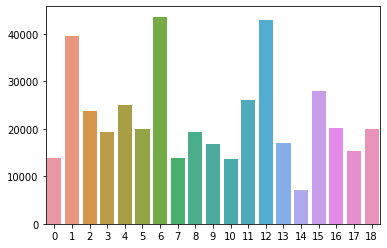

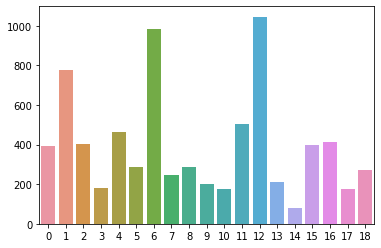

In [34]:
vc = data_train['behavior_id'].value_counts().sort_index()
sns.barplot(vc.index, vc.values)
plt.show()
vc = sub['behavior_id'].value_counts().sort_index()
sns.barplot(vc.index, vc.values)
plt.show()

In [35]:
sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   fragment_id  7500 non-null   int64
 1   behavior_id  7500 non-null   int64
dtypes: int64(2)
memory usage: 117.3 KB


In [ ]:
# result = data[data.age <0][['user_id','predicted_gender']]
# result['predicted_age'] = np.argmax(prob_w, axis=1) + 1
# result['predicted_gender'] = (result['predicted_gender'] > 0.5).astype(int) + 1
# result[['user_id','predicted_age','predicted_gender']].to_csv('submission.csv',index=False)

In [ ]:
# preds = prob_w